# Neuromodulated ratio estimator

In [1]:
import torch
import hypothesis
import matplotlib.pyplot as plt
import numpy as np

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from hypothesis.visualization.util import make_square

## Forward model and prior

In [2]:
prior = Uniform(-10, 10)

In [3]:
def simulate(inputs):
    return Normal(inputs, 1).sample().view(-1, 1).detach()

## Controller architecture

In [4]:
def allocate_controller(hidden=64):
    controller = torch.nn.Sequential(
        torch.nn.Linear(1, hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden, 1))
    
    return controller

## Modulated ratio estimator architecture

In [5]:
from hypothesis.nn.conditional_ratio_estimator import BaseConditionalRatioEstimator
from hypothesis.nn.neuromodulation import ModulatedReLU



class ModulatedRatioEstimator(BaseConditionalRatioEstimator):
    
    def __init__(self, layers=(64, 64, 64)):
        super(ModulatedRatioEstimator, self).__init__()
        # Build the model
        activations = []
        mappings = []
        mappings.append(torch.nn.Linear(1, layers[0]))
        for index in range(len(layers)):
            activation = ModulatedReLU(allocate_controller())
            activations.append(activation)
            mappings.append(activation)
            mappings.append(torch.nn.Linear(
                layers[index - 1], layers[index]))
        activation = ModulatedReLU(allocate_controller())
        activations.append(activation)
        mappings.append(activation)
        mappings.append(torch.nn.Linear(layers[-1], 1))
        # Network properties
        self.activations = activations
        self.model = torch.nn.Sequential(*mappings)
        
    def forward(self, inputs, outputs):
        log_ratios = self.log_ratio(inputs, outputs)
        
        return log_ratios.sigmoid(), log_ratios
    
    def log_ratio(self, inputs, outputs):
        # Update activation controller context
        for activation in self.activations:
            activation.update(inputs)
        log_ratios = self.model(outputs)
        
        return log_ratios

## Training

In [6]:
from hypothesis.nn.conditional_ratio_estimator import ConditionalRatioEstimatorCriterion as Criterion
from hypothesis.util.data import SimulatorDataset
from torch.utils.data import DataLoader

layers = (128, 128, 128)
dataset_size = 1000000
batch_size = 256
epochs = 10

dataset = SimulatorDataset(simulate, prior, size=dataset_size)

### Training of the modulated ratio estimator

In [7]:
modulated_ratio_estimator = ModulatedRatioEstimator(layers=layers)
modulated_ratio_estimator = modulated_ratio_estimator.to(hypothesis.accelerator)
modulated_ratio_estimator.train()
criterion = Criterion(modulated_ratio_estimator, batch_size).to(hypothesis.accelerator)
optimizer = torch.optim.Adam(modulated_ratio_estimator.parameters(), amsgrad=True)
losses = []
for epoch in range(epochs):
    data_loader = DataLoader(dataset, num_workers=4, shuffle=True, batch_size=batch_size, drop_last=True)
    for inputs, outputs in data_loader:
        inputs = inputs.to(hypothesis.accelerator).view(-1, 1)
        outputs = outputs.to(hypothesis.accelerator).view(-1, 1)
        loss = criterion(inputs, outputs)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
modulated_ratio_estimator = modulated_ratio_estimator.cpu()
modulated_ratio_estimator.eval()

print("Training completed!")

Training completed!


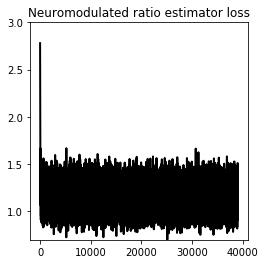

In [8]:
losses = np.array(losses)
plt.title("Neuromodulated ratio estimator loss")
plt.plot(range(len(losses)), losses, lw=2, color="black")
plt.ylim([0.7, 3])
make_square(plt.gca())
plt.show()

### Training of the traditional ratio estimator

In [9]:
from hypothesis.nn import ConditionalMLPRatioEstimator as MLPRatioEstimator

traditional_ratio_estimator = MLPRatioEstimator(shape_inputs=(1,), shape_outputs=(1,), layers=layers, activation=torch.nn.ReLU)
traditional_ratio_estimator = traditional_ratio_estimator.to(hypothesis.accelerator)
traditional_ratio_estimator.train()
criterion = Criterion(traditional_ratio_estimator, batch_size).to(hypothesis.accelerator)
optimizer = torch.optim.Adam(traditional_ratio_estimator.parameters(), amsgrad=True)
losses = []
for epoch in range(epochs):
    data_loader = DataLoader(dataset, num_workers=4, shuffle=True, batch_size=batch_size, drop_last=True)
    for inputs, outputs in data_loader:
        inputs = inputs.to(hypothesis.accelerator).view(-1, 1)
        outputs = outputs.to(hypothesis.accelerator).view(-1, 1)
        loss = criterion(inputs, outputs)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
traditional_ratio_estimator = traditional_ratio_estimator.cpu()
traditional_ratio_estimator.eval()

print("Training completed!")

Training completed!


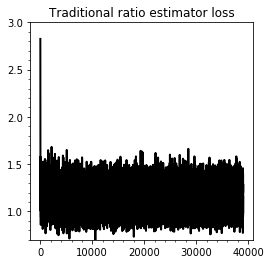

In [10]:
losses = np.array(losses)
plt.title("Traditional ratio estimator loss")
plt.plot(range(len(losses)), losses, lw=2, color="black")
plt.minorticks_on()
make_square(plt.gca())
plt.ylim([0.7, 3])
plt.show()

## Inference

In [11]:
truth = float(0)
observation = simulate(torch.tensor(truth)).view(-1, 1)
resolution = 1000
observations = observation.repeat(resolution, 1).view(-1, 1)
thetas = torch.linspace(-10, 10, 1000).view(-1, 1)

### Modulated ratio estimator

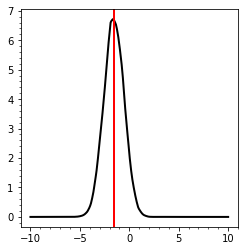

In [12]:
log_ratios = modulated_ratio_estimator.log_ratio(thetas, observations)

plt.plot(thetas.numpy(), log_ratios.exp().detach().numpy(), lw=2, color="black")
plt.axvline(observation.numpy(), color="red", lw=2)
plt.minorticks_on()
make_square(plt.gca())
plt.show()

### Traditional ratio estimator

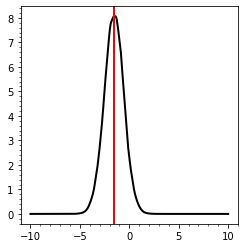

In [13]:
log_ratios = traditional_ratio_estimator.log_ratio(thetas, observations)

plt.plot(thetas.numpy(), log_ratios.exp().detach().numpy(), lw=2, color="black")
plt.axvline(observation.numpy(), color="red", lw=2)
plt.minorticks_on()
make_square(plt.gca())
plt.show()